In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
df = pd.read_parquet('df_final.parquet.gzip')
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id
0,2019-10-16 12:04:37+00:00,view,7900918,2053013556487520725,furniture.kitchen.chair,joie,102.709999,560842110
1,2019-10-16 12:04:37+00:00,view,1003317,2053013555631882655,electronics.smartphone,apple,952.150024,560842739
2,2019-10-16 12:04:37+00:00,view,2501929,2053013564003713919,appliances.kitchen.oven,asel,61.750000,525817175
3,2019-10-16 12:04:37+00:00,view,1004833,2053013555631882655,electronics.smartphone,samsung,172.169998,515456548
4,2019-10-16 12:04:37+00:00,cart,1004836,2053013555631882655,electronics.smartphone,samsung,229.410004,529758564


In [3]:
df.shape

(42448763, 8)

In [4]:
df = df.drop('category_id', axis=1)
df.shape

(42448763, 7)

In [5]:
df.isnull().sum()

event_time              0
event_type              0
product_id              0
category_code    13422656
brand             6011377
price                   0
user_id                 0
dtype: int64

In [6]:
df = df.dropna()
df.shape

(26701215, 7)

In [7]:
df.isnull().sum()

event_time       0
event_type       0
product_id       0
category_code    0
brand            0
price            0
user_id          0
dtype: int64

In [8]:
df = df.drop_duplicates()
df.shape

(22146517, 7)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22146517 entries, 0 to 7074793
Data columns (total 7 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   event_type     category           
 2   product_id     int64              
 3   category_code  object             
 4   brand          object             
 5   price          float32            
 6   user_id        int64              
dtypes: category(1), datetime64[ns, UTC](1), float32(1), int64(2), object(2)
memory usage: 1.1+ GB


In [10]:
df['price'].describe()

count    2.214652e+07
mean     3.527647e+02
std      3.655553e+02
min      0.000000e+00
25%      1.087100e+02
50%      2.184900e+02
75%      4.592100e+02
max      2.574070e+03
Name: price, dtype: float64

In [11]:
df[df['price'] <= 0]['event_type'].unique()

['view', 'cart']
Categories (3, object): ['cart', 'purchase', 'view']

In [12]:
file_path_parquet = 'df_total.parquet.gzip'
df.to_parquet(file_path_parquet, compression='gzip')

In [13]:
df = df[df['event_type'] == 'purchase']
df.shape

(453758, 7)

## RFM 계산

### 전체 주문에서 최근 주문일 구하기

In [14]:
last_timestamp = df['event_time'].max() + dt.timedelta(days=1)
last_timestamp

Timestamp('2019-11-01 23:59:16+0000', tz='UTC')

### 고객별 Recency, Frequency, Monetary 값 구하기

In [15]:
rfm = df.groupby('user_id').agg({'event_time' : lambda x: (last_timestamp - x.max()).days,
                                'product_id' : 'count',
                                'price' : 'sum'})
rfm

,event_time,product_id,price
user_id,,,
384989212,14,1,41.439999
401021311,11,1,231.639999
403013066,14,2,807.160034
410333972,1,1,591.250000
415873351,1,2,263.059998
...,...,...,...
566265448,1,1,592.010010
566267483,1,2,30.740000
566270060,1,2,147.419998


In [16]:
rfm.columns = ['Recency', 'Frequency', 'MonetaryValue']
rfm

,Recency,Frequency,MonetaryValue
user_id,,,
384989212,14,1,41.439999
401021311,11,1,231.639999
403013066,14,2,807.160034
410333972,1,1,591.250000
415873351,1,2,263.059998
...,...,...,...
566265448,1,1,592.010010
566267483,1,2,30.740000
566270060,1,2,147.419998


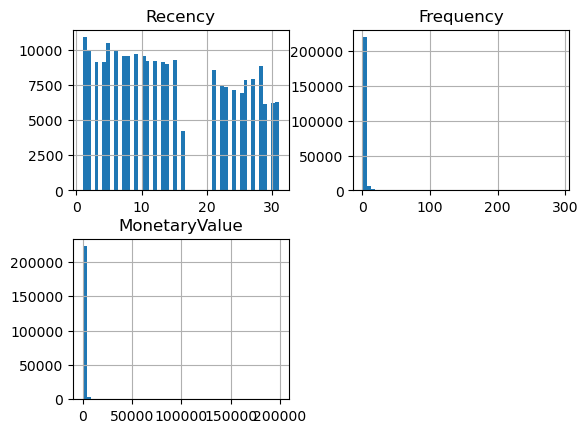

In [17]:
rfm.hist(bins=50);

### Scoring 기법
- R은 값이 낮을 수록 최근에 구매한 고객이기 때문에 높은 점수를 줄 예정입니다.
- F, M은 값이 높을 수록 높은 점수를 부여

In [18]:
list(range(5,0,-1))

[5, 4, 3, 2, 1]

In [19]:
cut_size=5
r_cut = pd.qcut(rfm['Recency'].rank(method='first'), cut_size, labels=list(range(5,0,-1)))
f_cut = pd.qcut(rfm['Frequency'].rank(method='first'), cut_size, labels=list(range(1,6)))
m_cut = pd.qcut(rfm['MonetaryValue'].rank(method='first'), cut_size, labels=list(range(1,6)))

In [20]:
rfm['R'] = r_cut
rfm['F'] = f_cut
rfm['M'] = m_cut
rfm

,Recency,Frequency,MonetaryValue,R,F,M
user_id,,,,,,
384989212,14,1,41.439999,3,1,1
401021311,11,1,231.639999,3,1,3
403013066,14,2,807.160034,3,4,4
410333972,1,1,591.250000,5,1,4
415873351,1,2,263.059998,5,4,3
...,...,...,...,...,...,...
566265448,1,1,592.010010,5,4,4
566267483,1,2,30.740000,5,5,1
566270060,1,2,147.419998,5,5,2


### RFM Segment

In [21]:
rfm["RFM_segment"] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment
user_id,,,,,,,
384989212,14,1,41.439999,3,1,1,311
401021311,11,1,231.639999,3,1,3,313
403013066,14,2,807.160034,3,4,4,344
410333972,1,1,591.250000,5,1,4,514
415873351,1,2,263.059998,5,4,3,543
...,...,...,...,...,...,...,...
566265448,1,1,592.010010,5,4,4,544
566267483,1,2,30.740000,5,5,1,551
566270060,1,2,147.419998,5,5,2,552


In [22]:
rfm["RFM_segment"].value_counts()

555    9164
455    5928
355    4261
554    3684
132    3675
       ... 
252     286
351     237
251     201
152     105
151      99
Name: RFM_segment, Length: 125, dtype: int64

### RFM Score

In [23]:
rfm["RFM_score"] = rfm[['R', 'F', 'M']].sum(axis=1)
rfm.head(2)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
user_id,,,,,,,,
384989212,14,1,41.439999,3,1,1,311,5
401021311,11,1,231.639999,3,1,3,313,7


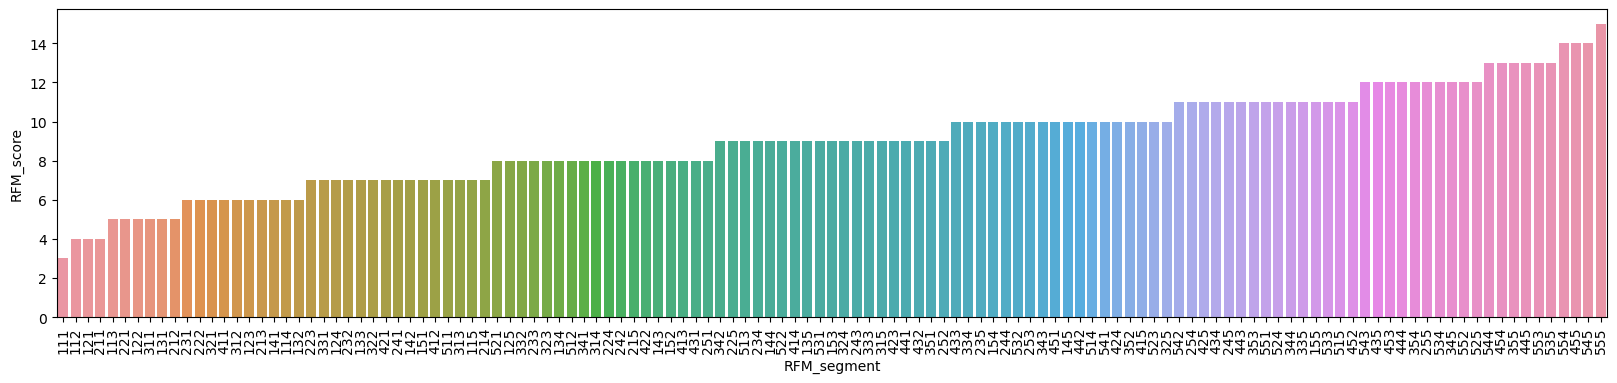

In [24]:
# RFM segment 값에 따라 정렬합니다.
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.barplot(data=rfm.sort_values('RFM_score'), x='RFM_segment', y='RFM_score');

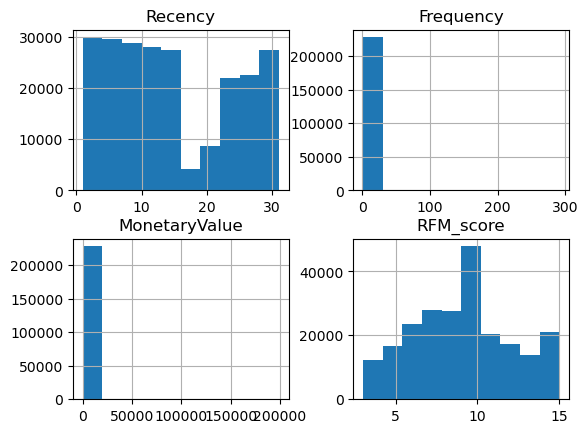

In [25]:
rfm.hist();

In [26]:
rfm.iloc[:,:-2]

,Recency,Frequency,MonetaryValue,R,F,M
user_id,,,,,,
384989212,14,1,41.439999,3,1,1
401021311,11,1,231.639999,3,1,3
403013066,14,2,807.160034,3,4,4
410333972,1,1,591.250000,5,1,4
415873351,1,2,263.059998,5,4,3
...,...,...,...,...,...,...
566265448,1,1,592.010010,5,4,4
566267483,1,2,30.740000,5,5,1
566270060,1,2,147.419998,5,5,2


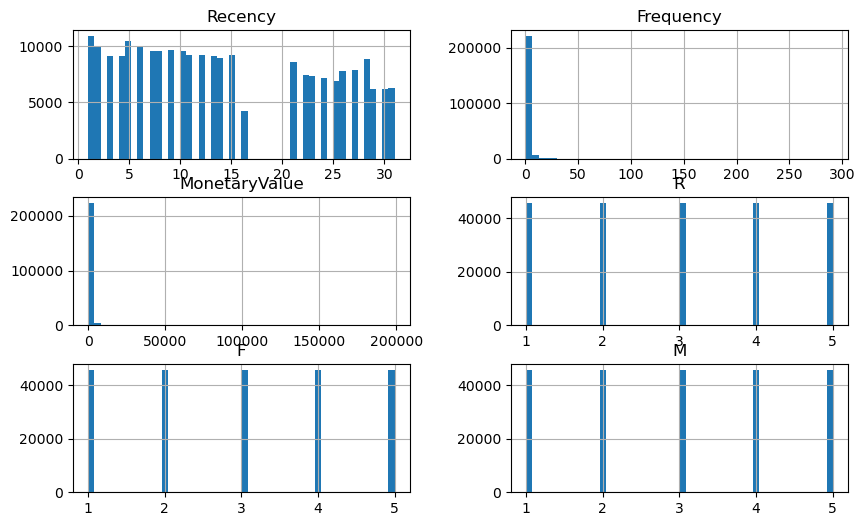

In [27]:
rfm.iloc[:,:-2].astype(float).hist(figsize=(10,6), bins=50);

In [28]:
rfm_score = rfm.groupby('RFM_score').agg({'Recency':'mean',
                                         'Frequency':'mean',
                                         'MonetaryValue':['mean', 'sum']})
rfm_score.style.background_gradient().format('{:,.0f}')

### qcut을 통한 고객군 나누기

In [29]:
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
user_id,,,,,,,,
384989212,14,1,41.439999,3,1,1,311,5
401021311,11,1,231.639999,3,1,3,313,7
403013066,14,2,807.160034,3,4,4,344,11
410333972,1,1,591.250000,5,1,4,514,10
415873351,1,2,263.059998,5,4,3,543,12


In [30]:
# qcut을 RFM_score에 따라 3단계 "silver", "gold", "platinum"로 고객군을 나눕니다.
cut_size = 3
labels = ['silver', 'gold', 'platinum']
rfm['RFM_class'] = pd.qcut(rfm['RFM_score'], cut_size, labels=labels)
rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
user_id,,,,,,,,,
384989212,14,1,41.439999,3,1,1,311,5,silver
401021311,11,1,231.639999,3,1,3,313,7,silver
403013066,14,2,807.160034,3,4,4,344,11,platinum
410333972,1,1,591.250000,5,1,4,514,10,gold
415873351,1,2,263.059998,5,4,3,543,12,platinum
...,...,...,...,...,...,...,...,...,...
566265448,1,1,592.010010,5,4,4,544,13,platinum
566267483,1,2,30.740000,5,5,1,551,11,platinum
566270060,1,2,147.419998,5,5,2,552,12,platinum


In [31]:
rfm.groupby('RFM_class')['RFM_score'].describe()

,count,mean,std,min,25%,50%,75%,max
RFM_class,,,,,,,,
silver,80296.0,5.791359,1.155453,3.0,5.0,6.0,7.0,7.0
gold,75516.0,8.937735,0.816090,8.0,8.0,9.0,10.0,10.0
platinum,72581.0,12.614486,1.371641,11.0,11.0,12.0,14.0,15.0


In [32]:
rfm.groupby('RFM_class').agg({'Recency':'mean', 'Frequency':'mean',
                             'MonetaryValue':['mean', 'sum', 'count']})

Recency Frequency MonetaryValue                    
                mean      mean          mean          sum  count
RFM_class                                                       
silver     20.762230  1.026141    185.046478   14858492.0  80296
gold       13.360626  1.309802    427.803894   32306038.0  75516
platinum    8.253124  3.753765   1670.235352  121227352.0  72581

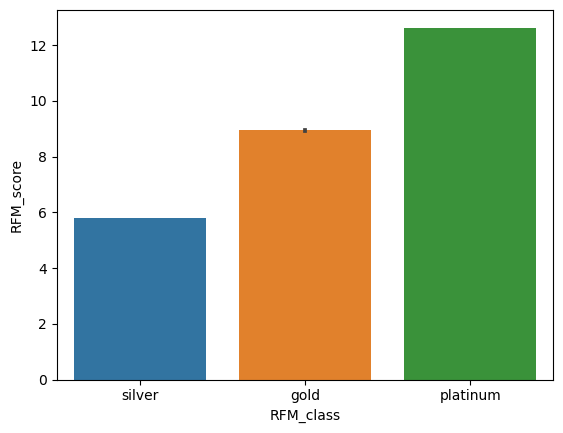

In [33]:
sns.barplot(data=rfm, x="RFM_class", y="RFM_score");

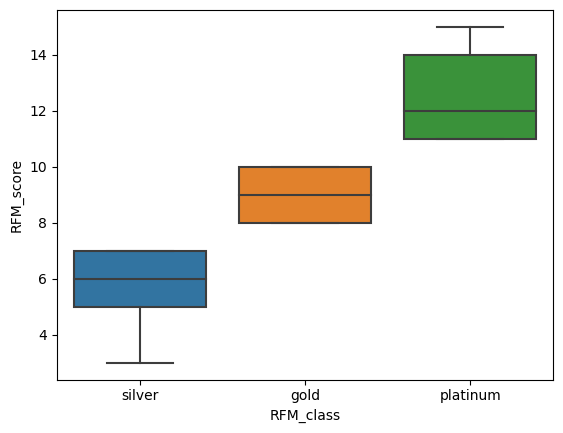

In [34]:
sns.boxplot(data=rfm, x="RFM_class", y="RFM_score");

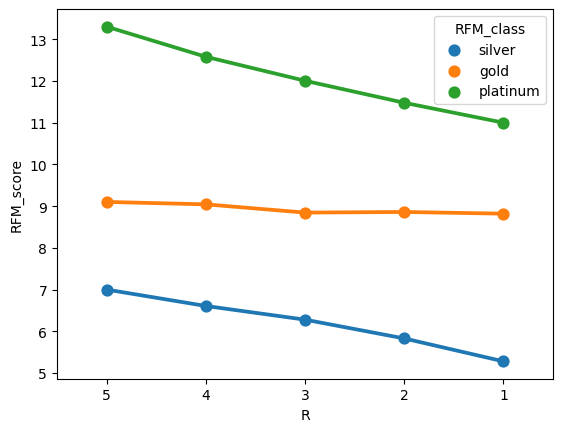

In [35]:
sns.pointplot(data=rfm, x='R', y='RFM_score', hue='RFM_class');

In [36]:
file_path_parquet = 'rfm_total.parquet.gzip'
rfm.to_parquet(file_path_parquet, compression='gzip')

In [37]:
pd.read_parquet(file_path_parquet).head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
user_id,,,,,,,,,
384989212,14,1,41.439999,3,1,1,311,5,silver
401021311,11,1,231.639999,3,1,3,313,7,silver
403013066,14,2,807.160034,3,4,4,344,11,platinum
410333972,1,1,591.250000,5,1,4,514,10,gold
415873351,1,2,263.059998,5,4,3,543,12,platinum


In [38]:
pd.read_parquet(file_path_parquet).tail()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
user_id,,,,,,,,,
566265448,1,1,592.010010,5,4,4,544,13,platinum
566267483,1,2,30.740000,5,5,1,551,11,platinum
566270060,1,2,147.419998,5,5,2,552,12,platinum
566274637,1,1,2011.630005,5,4,5,545,14,platinum
566278294,1,1,1661.089966,5,4,5,545,14,platinum
